In [24]:
%reset -f

In [25]:
import sys
from pathlib import Path
sys.path.append(str(Path.home()) + '/rpi-canary-eval/modules')

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from numpy import loadtxt
import tensorflow.keras.backend as K
import data_process, data_functions, data_generator, keras_model
from path import path_dict, col_seq_cc, col_seq_elx

In [27]:
%config Completer.use_jedi = False

In [28]:
pmpm = pd.read_pickle("../temp/pmpm_ccm.p")

In [29]:
pmpm.head()

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_IP  ALLOW_ER  \
0  2612620  201510        M               75          0       0.0       0.0   
1  2613447  201510        M               75       2159       0.0       0.0   
2  2613818  201510        M               75        176       0.0       0.0   
3  2740429  201510        M               61          0       0.0       0.0   
4  2736648  201510        M               61        213       0.0       0.0   

   CC_HYPOTHYROID  CC_AMI  CC_ALZHEIMER  ...  CC_HEPATITIS_A  \
0               0       0             0  ...               0   
1               0       0             0  ...               0   
2               0       0             0  ...               0   
3               0       0             0  ...               0   
4               0       0             0  ...               0   

   CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  \
0                     0                       0                     0   
1                     0                       0                     0   
2                     0                       0                     0   
3                     0                       0                     0   
4                     0                       0                     0   

   CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  \
0                       0                           0               0   
1                       0                           0               0   
2                       0                           0               0   
3                       0                           0               0   
4                       0                           0               0   

   CC_HEPATITIS_E  CC_DX_CNT  CC_DISAB_DX_CNT  
0               0          0                0  
1               0          7                0  
2               0          7                0  
3               0          1                0  
4               0          1                0  

[5 rows x 76 columns]

In [30]:
def get_training_date_range(pmpm, start, end):
    date_list = pmpm.MYR.sort_values().unique().tolist()
    start_index = date_list.index(start)
    end_index = date_list.index(end)
    return date_list[start_index:end_index+1]

In [31]:
def return_stacked_training_data(pmpm, train_start, train_end):
    
    training_period = get_training_date_range(pmpm.copy(), train_start, train_end)
    
    feature_start = [i for (i, _) in enumerate(training_period) if i%6==0]
    feature_end   = [i+5 for i in feature_start]
    label_start   = [feature_start[i] for (i,_) in enumerate(feature_start) if i>0]
    label_end     = [feature_end[i] for (i,_) in enumerate(feature_end) if i>0]

    feature_start = feature_start[:-1]
    feature_end   = feature_end  [:-1]

    print(f"Feature Start Month: {feature_start}")
    print(f"Feature End Month: {feature_end}")
    print(f"Label Start Month: {label_start}")
    print(f"Label End Month: {label_end}")
    
    for i, val in enumerate(feature_start):
        if i==0:
            training_features, sample_weight = data_generator.generate_data(pmpm.copy(), training_period[feature_start[i]], 
                                                             training_period[feature_end[i]], features=True, 
                                                             col_seq=col_seq_cc)
            training_labels, _  = data_generator.generate_data(pmpm.copy(), training_period[label_start[i]], 
                                                             training_period[label_end[i]], features=False, 
                                                             col_seq=col_seq_cc)
            training_features, training_labels = data_generator.make_intersection(training_features, training_labels)
            training_features, sample_weight   = data_generator.make_intersection(training_features, sample_weight)
            
            training_features = training_features.set_index('PERS_ID')
            training_labels = training_labels.set_index('PERS_ID')
            
            print(f"{training_features.shape} samples added with {training_labels.shape} labels and {sample_weight.shape} weights")

        else:
            new_training_features, new_sample_weights = data_generator.generate_data(pmpm.copy(), training_period[feature_start[i]], 
                                                             training_period[feature_end[i]], features=True, 
                                                             col_seq=col_seq_cc)
            new_training_labels, _  = data_generator.generate_data(pmpm.copy(), training_period[label_start[i]], 
                                                             training_period[label_end[i]], features=False, 
                                                             col_seq=col_seq_cc)
            
            new_training_features, new_training_labels = data_generator.make_intersection(new_training_features, new_training_labels)
            new_training_features, new_sample_weights = data_generator.make_intersection(new_training_features, new_sample_weights)
            
            new_training_features = new_training_features.set_index('PERS_ID')
            new_training_labels = new_training_labels.set_index('PERS_ID')

            print(f"{new_training_features.shape} samples added with {new_training_labels.shape} labels and {new_sample_weights.shape} weights")

            training_features = training_features.append(new_training_features, ignore_index=True)
            training_labels   = training_labels.append(new_training_labels, ignore_index=True)
            sample_weight     = sample_weight.append(new_sample_weights, ignore_index=True)

        print(f"Current Trainset size {training_features.shape}")
        
    return training_features, training_labels, sample_weight

In [32]:
%%time
train_data, training_labels, sample_weight = return_stacked_training_data(pmpm.copy(), 201601, 201712)

Feature Start Month: [0, 6, 12]
Feature End Month: [5, 11, 17]
Label Start Month: [6, 12, 18]
Label End Month: [11, 17, 23]
(360639, 74) samples added with (360639, 74) labels and (360639, 3) weights
Current Trainset size (360639, 74)
(340648, 74) samples added with (340648, 74) labels and (340648, 3) weights
Current Trainset size (701287, 74)
(341066, 74) samples added with (341066, 74) labels and (341066, 3) weights
Current Trainset size (1042353, 74)
CPU times: user 2min 13s, sys: 42.6 s, total: 2min 55s
Wall time: 2min 55s


In [33]:
train_data = train_data.dropna()

In [34]:
train_data

AGE_AT_MIDMONTH  MBR_GNDR    ALLOW_AMT    ALLOW_ER  ALLOW_IP  \
0                     39       0.0    78.166667    0.000000       0.0   
1                     36       1.0     0.000000    0.000000       0.0   
2                    102       1.0   621.500000   58.496667       0.0   
3                    102       0.0  1015.666667  223.476667       0.0   
4                    102       0.0   125.333333    0.000000       0.0   
...                  ...       ...          ...         ...       ...   
1042348               30       0.0     0.000000    0.000000       0.0   
1042349                4       0.0     0.000000    0.000000       0.0   
1042350               29       0.0    81.500000    0.000000       0.0   
1042351                4       1.0    36.500000    0.000000       0.0   
1042352               26       0.0    91.500000    0.000000       0.0   

         CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  ...  \
0              0             0                  0       0          0  ...   
1              0             0                  0       0          0  ...   
2              0             0                  0       0          0  ...   
3              0             0                  0       0          0  ...   
4              0             0                  0       0          0  ...   
...          ...           ...                ...     ...        ...  ...   
1042348        0             0                  0       0          0  ...   
1042349        0             0                  0       0          0  ...   
1042350        0             0                  0       0          0  ...   
1042351        0             0                  0       0          0  ...   
1042352        0             0                  0       0          0  ...   

         CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  \
0                         0        0                 0   
1                         0        0                 0   
2                         0        0                 0   
3                         0        0                 0   
4                         0        0                 0   
...                     ...      ...               ...   
1042348                   0        0                 0   
1042349                   0        0                 0   
1042350                   0        0                 0   
1042351                   0        0                 0   
1042352                   0        0                 0   

         CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  \
0                             0               0                0          0   
1                             0               0                0          0   
2                             0               0                0          0   
3                             0               0                0          0   
4                             0               0                0          0   
...                         ...             ...              ...        ...   
1042348                       0               0                0          0   
1042349                       0               0                0          0   
1042350                       0               0                0          0   
1042351                       0               0                0          0   
1042352                       0               0                0          0   

         CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  
0                 0                   0                 0  
1                 0                   0                 0  
2                 0                   0                 0  
3                 0                   0                 0  
4                 0                   0                 0  
...             ...                 ...               ...  
1042348           0                   0                 0  
1042349           0                   0                 0  
1042350           0  

In [35]:
training_labels = training_labels.dropna()

In [36]:
training_labels

AGE_AT_MIDMONTH  MBR_GNDR    ALLOW_AMT    ALLOW_ER  ALLOW_IP  \
0                     39       0.0    74.000000    0.000000       0.0   
1                     37       1.0    24.000000    0.000000       0.0   
2                    103       1.0   542.000000    0.000000       0.0   
3                    102       0.0  1017.166667  319.333333       0.0   
4                    102       0.0   143.833333    0.000000       0.0   
...                  ...       ...          ...         ...       ...   
1042348               31       0.0    51.666667    0.000000       0.0   
1042349                4       0.0    30.500000    0.000000       0.0   
1042350               30       0.0    85.333333    0.000000       0.0   
1042351                5       1.0    38.666667    0.000000       0.0   
1042352               27       0.0   353.000000  110.000000       0.0   

         CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  ...  \
0              0             0                  0       0          0  ...   
1              0             0                  0       0          0  ...   
2              0             0                  0       0          0  ...   
3              0             0                  5       0          0  ...   
4              0             0                  0       0          0  ...   
...          ...           ...                ...     ...        ...  ...   
1042348        0             0                  0       0          0  ...   
1042349        0             0                  0       0          0  ...   
1042350        0             0                  0       0          0  ...   
1042351        0             0                  0       0          0  ...   
1042352        0             0                  0       0          0  ...   

         CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  \
0                         0        0                 0   
1                         0        0                 0   
2                         0        0                 0   
3                         0        0                 0   
4                         0        0                 0   
...                     ...      ...               ...   
1042348                   0        0                 0   
1042349                   0        0                 0   
1042350                   0        0                 0   
1042351                   0        0                 0   
1042352                   0        0                 0   

         CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  \
0                             0               0                0          0   
1                             0               0                0          0   
2                             0               0                0          0   
3                             0               0                0          0   
4                             0               0                0          0   
...                         ...             ...              ...        ...   
1042348                       0               0                0          0   
1042349                       0               0                0          0   
1042350                       0               0                0          0   
1042351                       0               0                0          0   
1042352                       0               0                0          0   

         CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  
0                 0                   0                 0  
1                 0                   0                 0  
2                 0                   0                 0  
3                 0                   0                 0  
4                 0                   0                 0  
...             ...                 ...               ...  
1042348           0                   0                 0  
1042349           0                   0                 0  
1042350           0  

## Sample weight calculation

In [37]:
sample_weight

PERS_ID  0  weight
0        2561295  6     1.0
1        2561296  6     1.0
2        2562628  6     1.0
3        2562714  6     1.0
4        2562798  6     1.0
...          ... ..     ...
1042348  5026086  3     0.5
1042349  5032881  3     0.5
1042350  5034634  6     1.0
1042351  5038017  6     1.0
1042352  5038909  6     1.0

[1042353 rows x 3 columns]

In [38]:
sample_weight.weight.values

array([1., 1., 1., ..., 1., 1., 1.])

## Training

In [39]:
baseline_model = keras_model.make_model_6(input_shape=train_data.shape[1])
baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 74)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4800      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
__________

In [40]:
num_epochs = 20

#use this when multi-dim vectored output head
baseline_history = baseline_model.fit(train_data.values, training_labels.values, epochs=num_epochs, validation_split=0.1, 
                                      batch_size=128, verbose=1, sample_weight=sample_weight.weight.values)

Train on 938117 samples, validate on 104236 samples
Epoch 1/20
938117/938117 [==============================] - 20s 22us/step - loss: 74527.1541 - mean_absolute_error: 9.7551 - val_loss: 47004.0464 - val_mean_absolute_error: 6.1235
Epoch 2/20
938117/938117 [==============================] - 20s 21us/step - loss: 75274.4569 - mean_absolute_error: 8.8358 - val_loss: 46171.5947 - val_mean_absolute_error: 6.0940
Epoch 3/20
938117/938117 [==============================] - 20s 21us/step - loss: 74467.5186 - mean_absolute_error: 8.8583 - val_loss: 46246.3528 - val_mean_absolute_error: 6.0746
Epoch 4/20
938117/938117 [==============================] - 20s 21us/step - loss: 74394.9058 - mean_absolute_error: 8.8365 - val_loss: 44244.7681 - val_mean_absolute_error: 6.1793
Epoch 5/20
938117/938117 [==============================] - 20s 21us/step - loss: 74156.3104 - mean_absolute_error: 8.9417 - val_loss: 46406.9025 - val_mean_absolute_error: 6.2012
Epoch 6/20
938117/938117 [======================

In [41]:
baseline_history.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

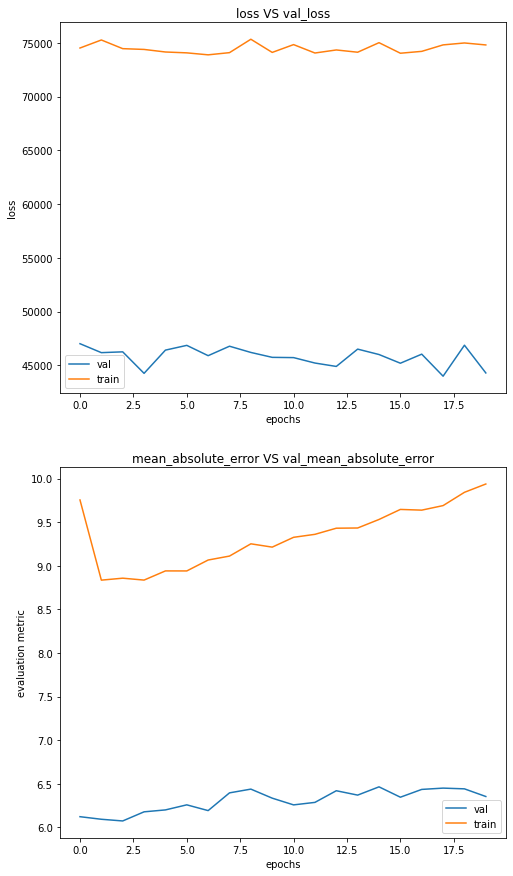

In [42]:
keras_model.plot_history(baseline_history, num_epochs, figsize=(8, 15))

In [43]:
latent_model = tf.keras.Model(baseline_model.input, baseline_model.get_layer("representation").output)

In [44]:
#freeze all the layers in both models
for layer in baseline_model.layers:
    layer.trainable=False
for layer in latent_model.layers:
    layer.trainable=False

In [45]:
## save the models
baseline_model.save('../temp/TF_Full_Model_m6_CCM_stacked')
latent_model.save('../temp/TF_Latent_Model_m6_CCM_stacked')

In [46]:
#save in S3
import boto3
s3 = boto3.client('s3')
bucket = 'cdphp-s3-us-e-p-pond'
s3.upload_file( str(Path.home()) + '/rpi-canary-eval/temp/TF_Latent_Model_m6_CCM_stacked',
                bucket, 
                'rpi/nneehal/MODELS/TF_Latent_Model_m6_CCM_stacked',
                ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})
s3.upload_file( str(Path.home()) + '/rpi-canary-eval/temp/TF_Full_Model_m6_CCM_stacked',
                bucket, 
                'rpi/nneehal/MODELS/TF_Full_Model_m6_CCM_stacked',
                ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})